In [1]:
import pathlib as plb
import tempfile

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import nilearn.image
import shutil
import SimpleITK as sitk
import pydicom
from nibabel.orientations import ornt_transform, axcodes2ornt, inv_ornt_aff, apply_orientation, io_orientation, aff2axcodes


### Subroutines

In [2]:
# Nifti reorientation
def reorient_nifti(img,
                   target_orientation=('L','A','S'),
                   verbose=False):
    new_ornt = axcodes2ornt(target_orientation)
    vox_array = img.get_fdata()
    affine = img.affine
    orig_ornt = io_orientation(img.affine)
    ornt_trans = ornt_transform(orig_ornt, new_ornt)
    orig_shape = vox_array.shape
    new_vox_array = apply_orientation(vox_array, ornt_trans)
    aff_trans = inv_ornt_aff(ornt_trans, orig_shape)
    new_affine = np.dot(affine, aff_trans)
    if verbose:
        print(f'{aff2axcodes(affine)} -> {aff2axcodes(new_affine)}')
    new_img = nib.Nifti1Image(new_vox_array, new_affine, img.header)
    return new_img

In [3]:
# SUV conversion
def conv_time(time_str):
    return (float(time_str[:2]) * 3600 + float(time_str[2:4]) * 60 + float(time_str[4:13]))

def calculate_suv_factor(dcm_path):
    ds = pydicom.dcmread(str(dcm_path))
    total_dose = ds.RadiopharmaceuticalInformationSequence[0].RadionuclideTotalDose
    start_time = ds.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime
    half_life = ds.RadiopharmaceuticalInformationSequence[0].RadionuclideHalfLife
    acq_time = ds.AcquisitionTime
    weight = ds.PatientWeight
    time_diff = conv_time(acq_time) - conv_time(start_time)
    act_dose = total_dose * 0.5 ** (time_diff / half_life)
    suv_factor = 1000 * weight / act_dose
    return suv_factor

def convert_pet(pet, suv_factor=1.0):
    affine = pet.affine
    pet_data = pet.get_fdata()
    pet_suv_data = (pet_data*suv_factor).astype(np.float32)
    pet_suv = nib.Nifti1Image(pet_suv_data, affine)
    return pet_suv 

In [4]:
# PET/CT resampling and alignement
def resample_nifti(ct_nii, suv_nii,
                   target_orientation, target_spacing):
    ct = nib.load(ct_nii)
    suv = nib.load(suv_nii)

    # reorient niftis
    ct = reorient_nifti(ct, target_orientation=target_orientation)
    suv = reorient_nifti(suv, target_orientation=target_orientation)

    # resample and align pet/ct
    orig_spacing = np.array(ct.header.get_zooms())
    orig_shape = ct.header.get_data_shape()
    target_affine = np.copy(ct.affine)
    target_affine[:3, :3] = np.diag(target_spacing / orig_spacing) @ ct.affine[:3, :3]
    target_shape = (orig_shape*(orig_spacing/target_spacing)).astype(int)

    ct_rs = nilearn.image.resample_img(ct, target_affine, target_shape,
                                    interpolation='continuous',
                                    fill_value=-1024)
    ct_rs.set_data_dtype(np.float32)

    suv_rs = nilearn.image.resample_to_img(suv, ct_rs,
                                            interpolation='continuous',
                                            fill_value=0)
    suv_rs.set_data_dtype(np.float32)

    nib.save(ct_rs, ct_nii.parent/('rsCT.nii.gz'))
    nib.save(suv_rs, suv_nii.parent/('rsSUV.nii.gz')) 

### Preprocessing

In [33]:
target_orientation = 'LAS'
target_spacing = [2.0, 2.0, 3.0]

In [34]:
ct_nii_pattern = '*gk*.nii.gz'
suv_nii_pattern = 'suv*.nii.gz'

In [37]:
# specify root directory containing all dicom directories (one per subject)
dicom_root = plb.Path('/Users/gitijavidi/Desktop/pet_tars/')
dicom_dirs = list(dicom_root.glob('SPC*'))
dicom_dirs = [d for d in dicom_dirs if d.is_dir()]
nifti_dir = dicom_root.parent/'nifti'
nifti_dir.mkdir(exist_ok=True)

print(f'found {len(dicom_dirs)} dicom directories')
print(dicom_dirs)

print(f'niftis will be stored in {nifti_dir}')


found 3 dicom directories
[PosixPath('/Users/gitijavidi/Desktop/pet_tars/SPC2bd065a-SPC2bd06ce'), PosixPath('/Users/gitijavidi/Desktop/pet_tars/SPC29aa17c-SPC29aa2a6'), PosixPath('/Users/gitijavidi/Desktop/pet_tars/SPC29aa17d-SPC29aa2ab')]
niftis will be stored in /Users/gitijavidi/Desktop/nifti


In [38]:
for dicom_dir in dicom_dirs:
    try:
        subject = dicom_dir.name
        # create nifti sub-directory 
        # (dirname = subject dicom dirname)
        nii_d = nifti_dir/subject
        nii_d.mkdir(exist_ok=True)
        print(f'processing {dicom_dir}')
        for d in (dicom_dir/'Metavol/FinalDicoms').glob('*'):
                print(d)
                first_dcm = next(d.glob('*.dcm'))
                print(next(d.glob('*.dcm')))
                ds = pydicom.read_file(first_dcm)
                modality = ds.Modality
                print(f'  converting {modality} ...')

                if modality == 'PT':
                    # select sample pet dicom file to read header
                    suv_corr_factor = calculate_suv_factor(first_dcm)

                # convert dicom directory to nifti
                f = nii_d/f'{modality}.nii.gz'
                reader = sitk.ImageSeriesReader()
                dicom_names = reader.GetGDCMSeriesFileNames(str(d))
                reader.SetFileNames(dicom_names)
                image = reader.Execute()
                sitk.WriteImage(image, str(f))
                print(f'    -> stored as {f}')

                if modality == 'PT':
                    print(f'  converting SUV ...')
                    g = nii_d/'SUV.nii.gz'
                    suv_pet_nii = convert_pet(nib.load(f), suv_factor=suv_corr_factor)
                    nib.save(suv_pet_nii, g)
                    print(f'    -> stored as {g}')
            
        print(f'  resample and align CT/SUV ...')
        resample_nifti(nii_d/'CT.nii.gz', nii_d/'SUV.nii.gz', target_orientation, target_spacing)
    except:
        print(f'-> failed {d}')


processing /Users/gitijavidi/Desktop/pet_tars/SPC2bd065a-SPC2bd06ce
/Users/gitijavidi/Desktop/pet_tars/SPC2bd065a-SPC2bd06ce/Metavol/FinalDicoms/1.2.840.113619.2.405.3.4228515281.463.1571145509.212.3
/Users/gitijavidi/Desktop/pet_tars/SPC2bd065a-SPC2bd06ce/Metavol/FinalDicoms/1.2.840.113619.2.405.3.4228515281.463.1571145509.212.3/000163-1.2.840.113619.2.405.3.4228515281.463.1571145509.555.163.dcm
  converting CT ...
    -> stored as /Users/gitijavidi/Desktop/nifti/SPC2bd065a-SPC2bd06ce/CT.nii.gz
/Users/gitijavidi/Desktop/pet_tars/SPC2bd065a-SPC2bd06ce/Metavol/FinalDicoms/1.2.840.113619.2.405.3.4228515281.463.1571145509.556
/Users/gitijavidi/Desktop/pet_tars/SPC2bd065a-SPC2bd06ce/Metavol/FinalDicoms/1.2.840.113619.2.405.3.4228515281.463.1571145509.556/000081-1.2.840.113619.2.405.4228515281.1571157197.229369.dcm
  converting PT ...
    -> stored as /Users/gitijavidi/Desktop/nifti/SPC2bd065a-SPC2bd06ce/PT.nii.gz
  converting SUV ...
    -> stored as /Users/gitijavidi/Desktop/nifti/SPC2bd0

### Visualization

(249, 249, 318) (249, 249, 318)


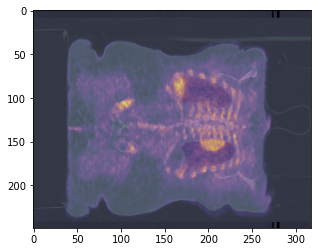

In [32]:
ct = nib.load(nii_d/'rsCT.nii.gz')
suv = nib.load(nii_d/'rsSUV.nii.gz')
slice_pos = ct.shape[2]//4
plt.imshow(ct.get_fdata()[:, slice_pos, :], cmap='bone')
plt.imshow(suv.get_fdata()[:, slice_pos, :], alpha=0.5, cmap='inferno')
print(ct.shape, suv.shape)
